In [78]:
import pandas as pd
import os
import numpy as np
import datetime as dt
from scipy.stats import norm
import warnings
from collections import Counter

warnings.filterwarnings('ignore')
cwd = os.getcwd()

In [69]:
# Modified: https://github.com/amauboussin/simple-ranking-system
#Input: a csv file containing all of the games to be analysed. 
#	Column1 - Team/Player 1, Column3 - Team/Player 2, 
#	Column 2 - Team 1's points, Column 4 = Team 2's points
#
#Output: Prints ranked teams/players and the score each one received under the simple ranking 
#	system in tab-delimited text (can be pasted into excel). 
#
#	Each teams' score is determined by the following equation:
#	score = average point differential + average score of opponents (strength of schedule)
#	since each team's score depends on other teams' score these equations need to be solved simultaneously
#	a more detailed description of the methodology is available at http://www.pro-football-reference.com/blog/?p=37

def mean(list):
    return (float(sum(list))/len(list))

class Team(object):
    def __init__(self, name, spreads, opponents):
        self.name = name
        self.spreads = spreads
        self.opponents = opponents
        
    def set_average_spread(self):
        self.spread = mean(self.spreads)

def SRS(data):
    games = data
    teams = {}
    
    #loop through games and construct team objects
    for index, game in games.iterrows():
        t1 = game['v']
        t2 = game['h']
        t1spread = int(game['final_v']) - int(game['final_h'])
        t2spread = -t1spread
        
        if t1 in teams:
            teams[t1].spreads.append(t1spread)
            teams[t1].opponents.append(t2)
        else:
            teams[t1] = Team(t1, [t1spread], [t2])
        
        if t2 in teams:
            teams[t2].spreads.append(t2spread)
            teams[t2].opponents.append(t1)
        else:
            teams[t2] = Team(t2, [t2spread], [t1])
            
    #calculate the means
    for team in teams.keys():
        teams[team].set_average_spread()

    #first matrix with the coefficients of each of the variables
    terms = []
    #second matrix with the constant term (-average spread)
    solutions = []
    
    for team in teams.keys():
        row = []
        
        #rating = average spread + average opponent rating
        #-> -average spread = -rating + average opponent rating
        #-> -average spread = -rating + 
        #(number of opponents/1) * (opponent 1 rating+opponent 2 rating...)
        #each row of the matrix describes right side equation
        for opp in teams.keys():
            if opp == teams[team].name:
                row.append(-1)
            elif opp in teams[team].opponents:
                row.append(1.0/len(teams[team].opponents))
            else:
                row.append(0)
        terms.append(row)
        
        #each row of this matrix describes the left side of the above equation
        solutions.append(-teams[team].spread )
    
    #solve the simultaneous equations using numpy
    array1 = np.array(terms)
    array2 = np.array(solutions)
    solutions = np.linalg.lstsq(array1, array2, rcond=None)[0]
    
    
    rankings = list(zip([teams[team].name for team in teams.keys()], [solution for solution in solutions]))
    rankings_dict = dict(rankings)
    
    rankings = sorted(rankings, reverse = True, key = lambda x: x[1])
    # print("Rank\tTeam\tScore")
    # for rank, pair in zip(range(1,len(rankings)+1), rankings):
    #    print('%s\t%s\t%.2f' % (rank,pair[0],pair[1]))
    return(rankings_dict)

## Preseason SRS

In [242]:
pre = pd.read_csv(cwd+'/seasons/2017-18_pre_odds_srs.csv')
pre = pre.set_index('Team').T.to_dict('list')
pre = {k:pre[k][0] for k in pre}

In [243]:
pre

{'GoldenState': 82.82062955,
 'Cleveland': 2.404786575,
 'Boston': 2.457837009,
 'SanAntonio': 4.705837392,
 'OklahomaCity': 3.935152621,
 'Houston': 4.632432824,
 'Minnesota': 1.253814306,
 'Milwaukee': -0.15041062,
 'Washington': 0.458940105,
 'Toronto': 0.11043991,
 'LAClippers': -0.937371011,
 'Philadelphia': -3.581591213,
 'Denver': 0.128228528,
 'NewOrleans': -2.590053758,
 'Miami': -2.287912214,
 'Utah': -1.978519663,
 'LALakers': -5.43644453,
 'Portland': -1.448000948,
 'Memphis': -3.722777421,
 'Dallas': -4.386666041,
 'Charlotte': -2.564681898,
 'Detroit': -4.280856108,
 'NewYork': -7.848011428,
 'Phoenix': -7.788301732,
 'Sacramento': -8.312447491,
 'Indiana': -7.435001096,
 'Atlanta': -10.23489167,
 'Orlando': -6.533547177,
 'Brooklyn': -9.364779321,
 'Chicago': -12.02583347}

In [244]:
season = pd.read_csv(cwd+'/odds_parsed_csv/2017-18_odds_parsedprobs.csv')
season.rename(columns={'Unnamed: 0': 'id'}, inplace=True)

In [245]:
r = SRS(season)

In [246]:
# Full Season SRS
r

{'Boston': 2.8340001110922617,
 'Cleveland': 0.27841915447923027,
 'Houston': 7.162340112203201,
 'GoldenState': 6.6368654925030635,
 'Brooklyn': -3.816457696140751,
 'Indiana': 1.591489013559098,
 'Philadelphia': 4.448195774133894,
 'Washington': 0.29476417101480257,
 'Miami': -0.2814316906781907,
 'Orlando': -4.876698659996171,
 'Charlotte': 0.13534953277490935,
 'Detroit': -0.26224082867088055,
 'Milwaukee': -0.430733208663127,
 'NewOrleans': 0.9808044697860698,
 'Memphis': -6.25019263589979,
 'Atlanta': -5.5032046840925615,
 'Dallas': -3.117662515417857,
 'Denver': 1.3401688098833446,
 'Utah': 3.3961065023438106,
 'Minnesota': 1.468568309321808,
 'SanAntonio': 2.082204672958174,
 'Sacramento': -7.021276973249185,
 'Portland': 1.9222300140266315,
 'Phoenix': -9.370674563610624,
 'Chicago': -7.05742155156244,
 'Toronto': 6.271333453981926,
 'NewYork': -3.635734804574492,
 'OklahomaCity': 2.744202373261995,
 'LAClippers': -0.08151793710461214,
 'LALakers': -1.6477829973455773}

# Calculate new SRS based on rolling window

In [237]:
def calc_season(df, rating):
    pred_spread = []
    rankings = {}
    data = df.copy()
    a_avg = data['final_v'].mean()
    h_avg = data['final_h'].mean()
    h_adv = h_avg-a_avg
    data['actual_spread'] = data['final_v'] - data['final_h']
    
    dates = data.Date.unique()
    window = 14
    for d in range(0,len(dates),window):
        current = data[data.Date.isin(list(dates[d:d+window]))].copy()
        current['pred_spread'] = current[['v', 'h']].apply(lambda x: h_adv + rating[x['v']] - rating[x['h']],axis=1)
#         std = 14.4
#         current['beat_vegas'] = 1-norm.cdf(0, current['pred_spread'] - current['spread_open'], std)
#         # home bet = 1, visitor bet=-1
#         current['v_or_h'] = current['pred_spread'].apply(lambda x: 1 if x<0 else -1)
                
        count = Counter(list(current.v) + list(current.h))
        
        # use game results for SRS.
        curr_ranking = SRS(current)
        rankings = rankings | curr_ranking
        # calculate previous and current rating standard deviations.
        pre_std = np.std(list(rating.values()))
        curr_std = np.std(list(curr_ranking.values()))
        
        # calculate posterior rating with n-observations.
        post = {}
        for team in curr_ranking:
            post[team] = post_mean(rating[team], pre_std, count[team], curr_ranking[team], curr_std)
        
        rating = post
        pred_spread.append(list(current['pred_spread']))
    
    pred_spread = [item for sublist in pred_spread for item in sublist]
    data['pred_spread'] = pred_spread   
    return data, rankings

## Posterior Rating Calculation
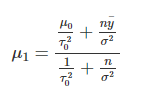

In [208]:
def post_mean(pre_m, pre_s, num, curr_m, curr_s):
    return ((pre_m/(pre_s)**2) + (num*curr_m/(curr_s)**2))/((1/(pre_s)**2) + (num/(curr_s)**2))

In [247]:
pred = calc_season(season, pre)
pred[0]

,id,Date,v,final_v,ml_v,h,final_h,ml_h,total_open,total_close,spread_open,spread_close,v_win_prob,h_win_prob,actual_spread,pred_spread
0,0,1017,Boston,99,166,Cleveland,102,-195,214.5,216.0,-4.0,-4.5,0.362541,0.637459,-3,2.429099
1,1,1017,Houston,122,364,GoldenState,121,-470,232.0,231.5,-9.0,-9.0,0.207212,0.792788,1,-75.812148
2,2,1018,Brooklyn,131,135,Indiana,140,-155,212.0,216.5,-3.5,-3.0,0.411788,0.588212,-9,0.446271
3,3,1018,Philadelphia,115,240,Washington,120,-300,215.5,217.5,-6.5,-6.5,0.281690,0.718310,-5,-1.664483
4,4,1018,Miami,109,-170,Orlando,116,145,207.0,205.5,3.0,3.5,0.606701,0.393299,-7,6.621684
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1306,1306,528,GoldenState,101,-265,Houston,92,218,210.0,208.0,4.0,6.0,0.697773,0.302227,9,4.640512
1307,1307,531,Cleveland,114,664,GoldenState,124,-1000,215.5,218.0,-11.5,-13.0,0.125858,0.874142,-10,-3.202492
1308,1308,603,Cleveland,103,447,GoldenState,122,-600,216.0,216.0,-12.5,-11.5,0.175791,0.824209,-19,-3.202492
1309,1309,606,GoldenState,110,-150,Cleveland,102,130,217.5,216.0,5.0,3.0,0.579832,0.420168,8,10.273613


In [248]:
pred[1]

{'Boston': -5.040036815462479,
 'Cleveland': -10.33333333333333,
 'Houston': -6.813621721122862,
 'GoldenState': 10.333333333333336,
 'Brooklyn': 0.06079084385744013,
 'Indiana': 1.1073446327683714,
 'Philadelphia': -1.5480225988700578,
 'Washington': -1.7142857142857155,
 'Miami': -8.999999999999998,
 'Orlando': -8.241179187596435,
 'Charlotte': 0.14917438993630386,
 'Detroit': 3.161484273288273,
 'Milwaukee': -8.74011299435028,
 'NewOrleans': -6.749999999999993,
 'Memphis': -5.175463192055002,
 'Atlanta': -5.49964938749609,
 'Dallas': -7.211311182816126,
 'Denver': 4.147519224603587,
 'Utah': -8.749999999999993,
 'Minnesota': -7.333333333333332,
 'SanAntonio': -7.333333333333332,
 'Sacramento': -5.93701082069009,
 'Portland': -7.1999999999999975,
 'Phoenix': -6.3435138835994405,
 'Chicago': -8.495656059670642,
 'Toronto': -12.72316384180791,
 'NewYork': -3.3266569892824913,
 'OklahomaCity': -3.714285714285714,
 'LAClippers': -6.910027234340955,
 'LALakers': -2.4197233302555086}

In [249]:
pred[0].to_csv('2017-18_rolling_srs.csv')

(Not used)

In [199]:
def bet(hw_p, f):
    r = 10/11
    p = max(hw_p, 1 - hw_p)
    if p < 0.5238:
        return 0
    bet = f*((p*r + p - 1)/r)
    return bet

In [205]:
def bet_sim(df, start, f):
    bet_df = df.copy()
    bet_df['bet_size'] = bet_df['beat_vegas'].apply(lambda x: bet(max(x, 1-x), f))
    bet_df['result'] = bet_df[['v_or_h', 'actual_spread']].apply(lambda x: 1 if (x['v_or_h']&x['actual_spread']>0)or(x['v_or_h']&x['actual_spread']<0) else 1)
    bet_df['bank'] = start
    for i, row in df.iterrows():  
        if row['result'] == 1:
            if i == 0:
                bet_df.at[i,'bank'] = start + start * bet_df.at[i,'bet_size']
            elif i > 0:
                bet_df.at[i,'bank'] = bet_df.at[i-1,'bank'] + bet_df.at[i-1,'bank'] * bet_df.at[i,'bet_size']
        else:
            if i == 0:
                bet_df.at[i,'bank'] = start 
            else:
                bet_df.at[i,'bank'] = bet_df.at[i-1,'bank']
        